In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [1]:
import numpy as np
from PyMPDATA_examples.Shipway_and_Hill_2012 import MPDATA, Settings, Formulae, si, const, convert_to, DropletActivation
from PyMPDATA_examples.Shipway_and_Hill_2012.plot import plot, plot_3d 
from PyMPDATA_examples.utils.show_plot import show_plot
from PyMPDATA.arakawa_c.enumerations import ARG_DATA_INNER, ARG_DATA, ONE_FOR_STAGGERED_GRID
from PyMPDATA import Options
import numba
import os
from matplotlib import pyplot

In [2]:
# note: NR=1 -> bulk
BASE_DT = .25*si.s
AUTO_DT = 0
NRS = (32, 16, 64, 128)
DTS = (AUTO_DT, BASE_DT/2, BASE_DT*2)
DZS = (100*si.m, 25*si.m, 50*si.m, 200*si.m)

if 'CI' in os.environ:
    NRS = (min(NRS),)
    DTS = (min(DTS),)
    DZS = (min(DZS),)

R_MIN = 1 * si.um
R_MAX = 20.2 * si.um

VERTVELO = 2.5*si.m/si.s
N_CCN_HALO = 500/si.mg
T_MAX = 15*si.minutes
P0 = 1007*si.hPa
Z_MAX = 3200*si.m

OPTIONS = (
    Options(n_iters=3, flux_corrected_transport=True),
    Options(n_iters=2, flux_corrected_transport=True),
    Options(n_iters=1),
)

In [3]:
def label(options, nr, dz, dt):
    return f"nr={nr}_dz={dz}_dt={dt}_opt={options}"

def adapt_dt(nr, dz):
    r_ratio = NRS[0] / nr
    z_ratio = dz / DZS[0]
    if r_ratio == 1 or z_ratio == 1:
        return BASE_DT * r_ratio * z_ratio
    return BASE_DT * min(r_ratio, z_ratio)

Simulating 14400 timesteps using nr=32_dz=25.0_dt=0.0625_opt={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 14400 timesteps using nr=64_dz=25.0_dt=0.0625_opt={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 14400 timesteps using nr=128_dz=25.0_dt=0.0625_opt={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 7200 timesteps using nr=32_dz=50.0_dt=0.125_opt={

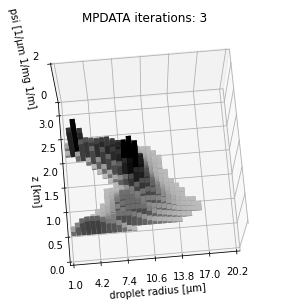

HTML(value="<a href='./fig_3d_n_iters=3.pdf' target='_blank'>./fig_3d_n_iters=3.pdf</a><br>")

Simulating 7200 timesteps using nr=32_dz=100.0_dt=0.125_opt={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 1800 timesteps using nr=32_dz=100.0_dt=0.5_opt={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 7200 timesteps using nr=64_dz=100.0_dt=0.125_opt={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 14400 timesteps using nr=128_dz=100.0_dt=0.0625_opt={'n

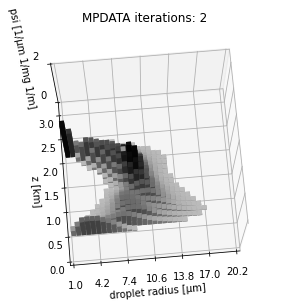

HTML(value="<a href='./fig_3d_n_iters=2.pdf' target='_blank'>./fig_3d_n_iters=2.pdf</a><br>")

Simulating 7200 timesteps using nr=32_dz=100.0_dt=0.125_opt={'n_iters': 2, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 1800 timesteps using nr=32_dz=100.0_dt=0.5_opt={'n_iters': 2, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 7200 timesteps using nr=64_dz=100.0_dt=0.125_opt={'n_iters': 2, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 14400 timesteps using nr=128_dz=100.0_dt=0.0625_opt={'n

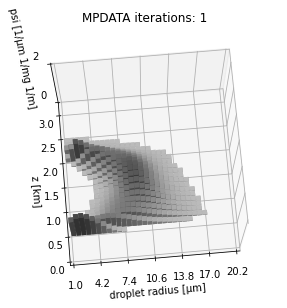

HTML(value="<a href='./fig_3d_n_iters=1.pdf' target='_blank'>./fig_3d_n_iters=1.pdf</a><br>")

Simulating 7200 timesteps using nr=32_dz=100.0_dt=0.125_opt={'n_iters': 1, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': False, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 1800 timesteps using nr=32_dz=100.0_dt=0.5_opt={'n_iters': 1, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': False, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 7200 timesteps using nr=64_dz=100.0_dt=0.125_opt={'n_iters': 1, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': False, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}
Simulating 14400 timesteps using nr=128_dz=100.0_dt=0.0625_opt=

In [4]:
outputs = {}
ANIM = False
for options in OPTIONS:
    for idz, dz in enumerate(sorted(DZS)):
        for inr, nr in enumerate(sorted(NRS)):
            for idt, dt in enumerate(sorted(DTS)):
                if dt == AUTO_DT:
                    dt = adapt_dt(nr, dz)
                    
                key = label(options, nr, dz, dt)
                if key in outputs:
                    continue
                if idt != 0 and (dz != DZS[0] or nr != NRS[0]):
                    continue
                if nr < NRS[0] and dz != DZS[0]:
                    continue
                if dz > DZS[0] and nr != NRS[0]:
                    continue

                settings = Settings(
                    w_1=VERTVELO, nr=nr, dt=dt, dz=dz, t_max=T_MAX, 
                    r_min=R_MIN, r_max=R_MAX, p0=P0, z_max=Z_MAX
                )
                print(f"Simulating {settings.nt} timesteps using {key}")

                mpdata = MPDATA(
                    nr=nr,
                    nz=settings.nz, 
                    dt=settings.dt, 
                    qv_of_zZ_at_t0 = lambda zZ: settings.qv(zZ*settings.dz),
                    g_factor_of_zZ = lambda zZ: settings.rhod(zZ*settings.dz), # TODO #239 spectral coord
                    options=options,
                    activation_bc=DropletActivation(N_CCN_HALO, settings.dr, settings.dz)
                )

                output = {k: np.zeros((settings.nz, settings.nt+1)) for k in ('qv', 'S', 'ql', 'act_frac', 'reldisp')}

                halo = mpdata.options.n_halo
                dpsi_shape = mpdata['ql'].advectee.get().shape    

                @numba.experimental.jitclass([('dpsi_cond', numba.float64[:,:])])
                class PostIter:
                    def __init__(self):
                        self.dpsi_cond = np.zeros(dpsi_shape)

                    def __call__(self, flux, g_factor, t, it):
                        if it == 0:
                            self.dpsi_cond[:] = 0
                        flux_wo_halo = flux[ARG_DATA_INNER][halo:-halo, halo-1:halo-1 + nr+ONE_FOR_STAGGERED_GRID]
                        self.dpsi_cond[:] -= (
                            (flux_wo_halo[:,1:] - flux_wo_halo[:,:-1]) 
                            / 
                            g_factor[ARG_DATA][halo:-halo, halo:-halo]
                        )
                post_iter = PostIter() if nr > 1 else None

                assert 't' not in output and 'z' not in output
                output['t'] = np.linspace(0, settings.nt*settings.dt, settings.nt+1, endpoint=True)
                output['z'] = np.linspace(settings.dz/2, (settings.nz-1/2)*settings.dz, settings.nz, endpoint=True)
                output['qv'][:,0] = mpdata['qv'].advectee.get()

                prof = {}
                prof['rhod'] = settings.rhod(output['z'])
                prof['T'] = Formulae.T(prof['rhod'], settings.thd(output['z']))
                prof['p'] = Formulae.p(prof['rhod'], prof['T'], output['qv'][:,0])
                prof['pvs'] = Formulae.pvs_Celsius(prof['T']-const.T0)

                Gvec = settings.rhod(settings.z_vec)
                Gscl = prof['rhod']

                for t in range(settings.nt):
                    C = settings.w((t+.5) * settings.dt) * settings.dt / settings.dz
                    advector_0 = Gvec * C
                    mpdata['qv'].advector.get_component(0)[:] = advector_0
                    mpdata['qv'].advance(1)

                    qv = mpdata['qv'].advectee.get()
                    RH = Formulae.pv(prof['p'], qv) / prof['pvs']

                    if nr==1:
                        mpdata['ql'].advector.get_component(0)[:] = advector_0
                    else:
                        mpdata['ql'].advector.get_component(0)[:, :] = np.repeat(advector_0.reshape(1,-1).T, nr, axis=1)
                        mpdata['ql'].advector.get_component(1)[:, :] = (
                            # scalar
                            settings.ksi_1 * settings.dt / settings.dr # m2/s * s / m
                            # column
                            * np.repeat((Gscl * (np.maximum(1, RH)-1)).reshape(1,-1).T, nr+1, axis=1) # kg/m3
                            # spectrum
                            / np.repeat(settings.bin_boundaries.reshape(1,-1), settings.nz, axis=0) # m-1       
                        )
                        GC_max = [
                            np.amax(mpdata['ql'].advector.get_component(d)[:,0]) for d in range(2)
                        ]
                        for d in range(2):
                            if GC_max[d] > 1:
                                raise Exception(f"max(GC) = {GC_max[1]} > 1 for d={d}")
                    mpdata['ql'].advance(1, post_iter=post_iter)

                    if nr==1:
                        ql = mpdata['ql'].advectee.get()
                        # note: this is possibly too inaccurate, would better iterate (but bulk is not our aim here)
                        # note: also, something along these lines could be added: assert not np.logical_and(S<1, ql>0).any()
                        dql = np.maximum(0, qv * (1 - 1/RH))
                        ql += dql
                    else:
                        psi = mpdata['ql'].advectee.get()

                        # advection/conservation of n/V, but G_factor=G_z*G_r=rho(z)*1, so psi=n/V/rho

                        def moment(data, l):
                            return np.sum(np.dot(data, settings.dr_power[l+1]/(l+1)), axis=1)*settings.dz

                        dql_cond = 4/3*np.pi*const.rho_l*moment(post_iter.dpsi_cond, 3)
                        ql = 4/3*np.pi*const.rho_l*moment(psi, 3)

                        N_tot = moment(psi, 0)
                        output['act_frac'][:,t+1] = N_tot / N_CCN_HALO

                        with np.errstate(divide='ignore', invalid='ignore'):
                            mom1 = moment(psi, 1) / N_tot
                            mom2 = moment(psi, 2) / N_tot
                            reldisp = np.sqrt(mom2 - mom1**2) / mom1
                        reldisp[N_tot/N_CCN_HALO < .05] = np.nan
                        output['reldisp'][:, t+1] = reldisp

                    qv -= dql_cond

                    output['ql'][:,t+1] = ql    
                    output['qv'][:,t+1] = qv
                    output['S'][:,t+1] = RH - 1

                    if nr>1 and NRS[0] and dt == BASE_DT and dz == DZS[0]:
                        anim = ANIM and 'CI' not in os.environ and (dql_cond > 0).any()
                        if anim or t==int(settings.t_1/dt):
                            plot_3d(psi, settings, options, R_MIN, R_MAX, max_height=2 / si.mg / si.um)
                        if anim:
                            pyplot.savefig(f'anim_frame_n_iters={options.n_iters}_frame={t:05d}.png')
                        if t == int(settings.t_1/dt):
                            show_plot(f'fig_3d_n_iters={options.n_iters}.pdf')
                        if anim:
                            pyplot.close()
                            
                outputs[key] = output

Plotting results for nr 32:
nr=32_dz=100.0_dt=0.25_opt={'n_iters': 3, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


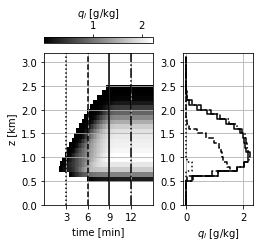

HTML(value="<a href='./fig_prof_ql_n_iters=3.pdf' target='_blank'>./fig_prof_ql_n_iters=3.pdf</a><br>")

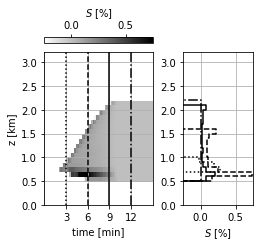

HTML(value="<a href='./fig_prof_S_n_iters=3.pdf' target='_blank'>./fig_prof_S_n_iters=3.pdf</a><br>")

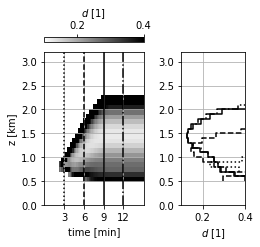

HTML(value="<a href='./fig_prof_d_n_iters=3.pdf' target='_blank'>./fig_prof_d_n_iters=3.pdf</a><br>")

nr=32_dz=100.0_dt=0.25_opt={'n_iters': 2, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': True, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


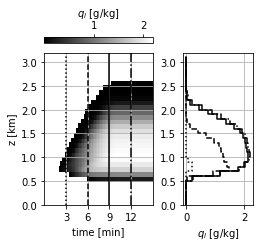

HTML(value="<a href='./fig_prof_ql_n_iters=2.pdf' target='_blank'>./fig_prof_ql_n_iters=2.pdf</a><br>")

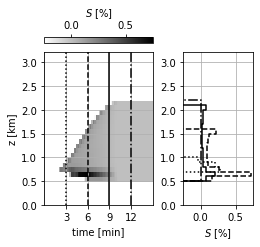

HTML(value="<a href='./fig_prof_S_n_iters=2.pdf' target='_blank'>./fig_prof_S_n_iters=2.pdf</a><br>")

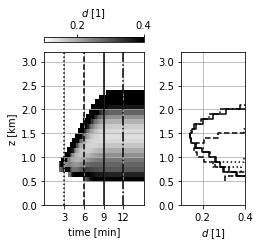

HTML(value="<a href='./fig_prof_d_n_iters=2.pdf' target='_blank'>./fig_prof_d_n_iters=2.pdf</a><br>")

nr=32_dz=100.0_dt=0.25_opt={'n_iters': 1, 'infinite_gauge': False, 'epsilon': 1e-15, 'divergent_flow': False, 'flux_corrected_transport': False, 'third_order_terms': False, 'non_zero_mu_coeff': False, 'dimensionally_split': False, 'dtype': <class 'numpy.float64'>, 'DPDC': False}


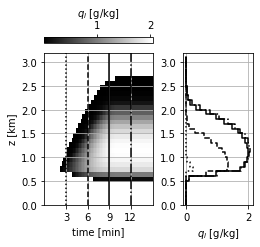

HTML(value="<a href='./fig_prof_ql_n_iters=1.pdf' target='_blank'>./fig_prof_ql_n_iters=1.pdf</a><br>")

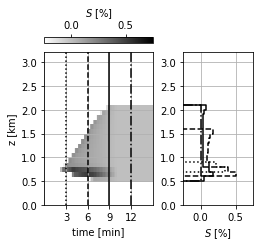

HTML(value="<a href='./fig_prof_S_n_iters=1.pdf' target='_blank'>./fig_prof_S_n_iters=1.pdf</a><br>")

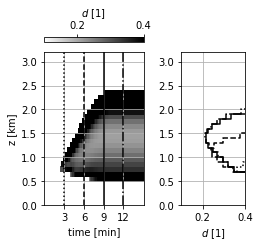

HTML(value="<a href='./fig_prof_d_n_iters=1.pdf' target='_blank'>./fig_prof_d_n_iters=1.pdf</a><br>")

In [5]:
cmap='gray'
rasterized=False
figsize=(3.5,3.5)
for nr in (NRS[0],):
    for dz in (DZS[0],):
        for dt in (DTS[0],):
            print("Plotting results for nr {}:".format(nr))
            if dt == AUTO_DT:
                dt = adapt_dt(nr, dz)
            for options in OPTIONS:
                key = label(options, nr, dz, dt)
                print(key)
        #         plot(var='qv', mult=1e3, label='$q_v$ [g/kg]', output=outputs[f'{key}'], cmap=cmap, threshold=1e-3)
        #         show_plot()
                plot(var='ql', mult=1e3, label='$q_l$ [g/kg]', output=outputs[f'{key}'], cmap=cmap, threshold=1e-3, figsize=figsize)
                show_plot(f'fig_prof_ql_n_iters={options.n_iters}.pdf')
                plot(var='S', mult=1e2, label='$S$ [%]', range=(-.25, .75), output=outputs[f'{key}'], cmap=cmap+'_r', figsize=figsize)
                show_plot(f'fig_prof_S_n_iters={options.n_iters}.pdf')
        #         plot(var='act_frac', mult=1e2, label='$N/N_{CCN}$ [%]', output=outputs[f'{key}'], cmap=cmap, threshold=1e-3, figsize=figsize)
        #         show_plot()
                plot(var='reldisp', mult=1, label='$d$ [1]', range=(0.1, 0.4), output=outputs[f'{key}'], cmap=cmap+'_r', figsize=figsize)
                show_plot(f'fig_prof_d_n_iters={options.n_iters}.pdf')

In [6]:
from matplotlib import pylab
import matplotlib

Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 64:
Plotting results for nr 64:
Plotting results for nr 64:
Plotting results for nr 128:
Plotting results for nr 128:
Plotting results for nr 128:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 64:
Plotting results for nr 64:
Plotting results for nr 64:
Plotting results for nr 128:
Plotting results for nr 128:
Plotting results for nr 128:
Plotting results for nr 16:
Plotting results for nr 16:
Plotting results for nr 16:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:


<ipython-input-7-5341fbf5c57c>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(gs[
<ipython-input-7-5341fbf5c57c>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(gs[
<ipython-input-7-5341fbf5c57c>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be creat

Plotting results for nr 64:
Plotting results for nr 64:
Plotting results for nr 64:
Plotting results for nr 128:
Plotting results for nr 128:
Plotting results for nr 128:
Plotting results for nr 32:
Plotting results for nr 32:
Plotting results for nr 32:


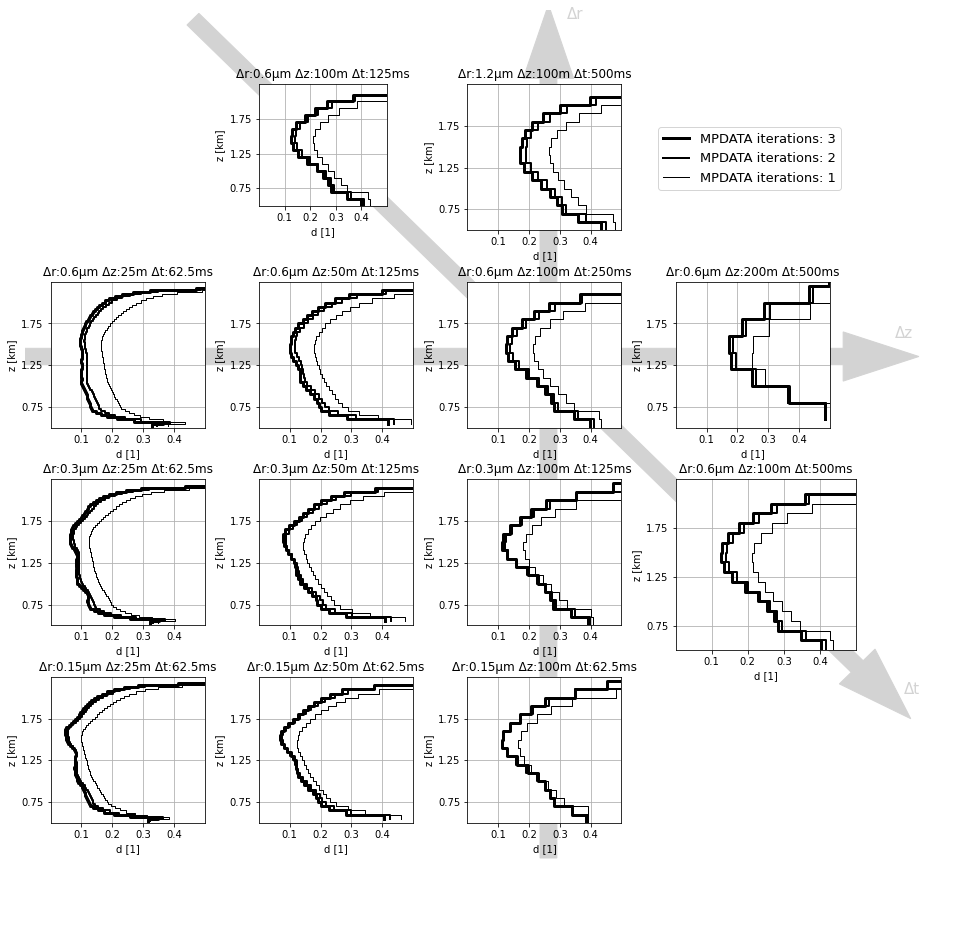

HTML(value="<a href='./fig_dt_dr_dz.pdf' target='_blank'>./fig_dt_dr_dz.pdf</a><br>")

In [7]:
figsize=(17, 17)
fig = pylab.figure(constrained_layout=False, figsize=figsize)
sz = 16
gs = fig.add_gridspec(4*sz+9+2, 4*sz+9)
ax = fig.add_subplot(gs[0:-1,0:-1])
ax.plot([], [], color='white')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.arrow(0.18,.99,.71,-.71, width=.018, color='lightgray') # Δt
ax.arrow(.56,.07,0,.855, width=.018, color='lightgray') # Δr
ax.arrow(0,.62,.875,0, width=.018, color='lightgray') # Δz
ax.axis('off')
ax.annotate("Δt", xy=(0, 0), xytext=(.94, .25), color='lightgray', size=15)
ax.annotate("Δr", xy=(0, 0), xytext=(.58, .99), color='lightgray', size=15)
ax.annotate("Δz", xy=(0, 0), xytext=(.93, .64), color='lightgray', size=15)

plotted = {}
for idz, dz in enumerate(sorted(DZS)):
    for inr, nr in enumerate(sorted(NRS)):
        for idt, dt in enumerate(sorted(DTS)):
            if dt == AUTO_DT:
                dt = adapt_dt(nr, dz)
            if label(OPTIONS[0], nr, dz, dt) not in outputs:
                continue
            if idt == 0:
                ax = fig.add_subplot(gs[
                    2+sz*inr+4:2+sz*(inr+1)-4 + 4, 
                    2+sz*idz:2+sz*(idz+1)-4
                ])
            else:
                if idt == 1:
                    ax = fig.add_subplot(gs[
                        2+4:2+sz-4-2 + 4, 
                        18:18+sz-4-2
                    ])
                elif idt == 2:
                    ax = fig.add_subplot(gs[
                        34+4:34+sz-4+2 + 4, 
                        50:50+sz-4+2
                    ])                    
                else:
                    assert False
            for options in OPTIONS:
                key = label(options, nr, dz, dt)
                if key in plotted:
                    continue
                print("Plotting results for nr {}:".format(nr))
            
                t = int(settings.t_1/dt)
                ax.step(
                    outputs[key]['reldisp'][:, t],
                    (outputs[key]['z']-dz/2) / 1000,
                    where='pre',
                    label=f"MPDATA iterations: {options.n_iters}",
                    color='k',
                    linewidth=options.n_iters
                )
                ax.grid()
                ax.set_ylabel('z [km]')
                ax.set_xlabel('d [1]')
                ax.set_xlim(0, 0.5)
                ax.set_xticks(np.arange(.1,.4,.1))
                ax.set_yticks((.75,1.25,1.75,))
                ax.set_ylim(.5, 2.25)
                ax.set_title(f"Δr:{(R_MAX-R_MIN)/nr/1e-6:.2g}μm Δz:{dz:.3g}m Δt:{1e3*dt:.3g}ms")
                plotted[key] = True
                if len(plotted) == 3:
                    ax.legend(bbox_to_anchor=(3.9, 2.1), loc='upper left', prop={'size': 13})

show_plot('fig_dt_dr_dz.pdf')